See als watersheed from edges question here: http://stackoverflow.com/questions/29573126/image-boundary-finding-and-filling

Landsat Bands: http://igett.delmar.edu/Resources/Remote%20Sensing%20Technology%20Training/Landsat_bands-sm.pdf

file:///C:/Users/Gennadii/Downloads/remotesensing-06-04173-v2.pdf - water indices
water detection http://cgis.utcluj.ro/iason-vcenter/index.php?s=lectii_execute&lesID=9&pagID=14
arcgis NDVI http://resources.arcgis.com/en/help/main/10.1/index.html#//009t00000052000000
image indices http://www.slideshare.net/kabiruddin/introduce-variable
USGS frequent bands http://landsat.usgs.gov/best_spectral_bands_to_use.php
USGS landsat plans https://calval.cr.usgs.gov/wordpress/wp-content/uploads/14.010_Scaramuzza_Landsat-Higher-Level-product-plans-Pat.pdf


Check if DTW can be used to reconstruct missing data under clouds:

https://en.wikipedia.org/wiki/Dynamic_time_warping

https://hal.archives-ouvertes.fr/file/index/docid/636814/filename/Spatio-Temporal_Reasoning_for_the_Classification_of_Satellite_Image_Time_Series_.pdf

file:///C:/Users/Gennadii/Downloads/FastDTW_paper.pdf

In [1]:
from utils.image_plot import *

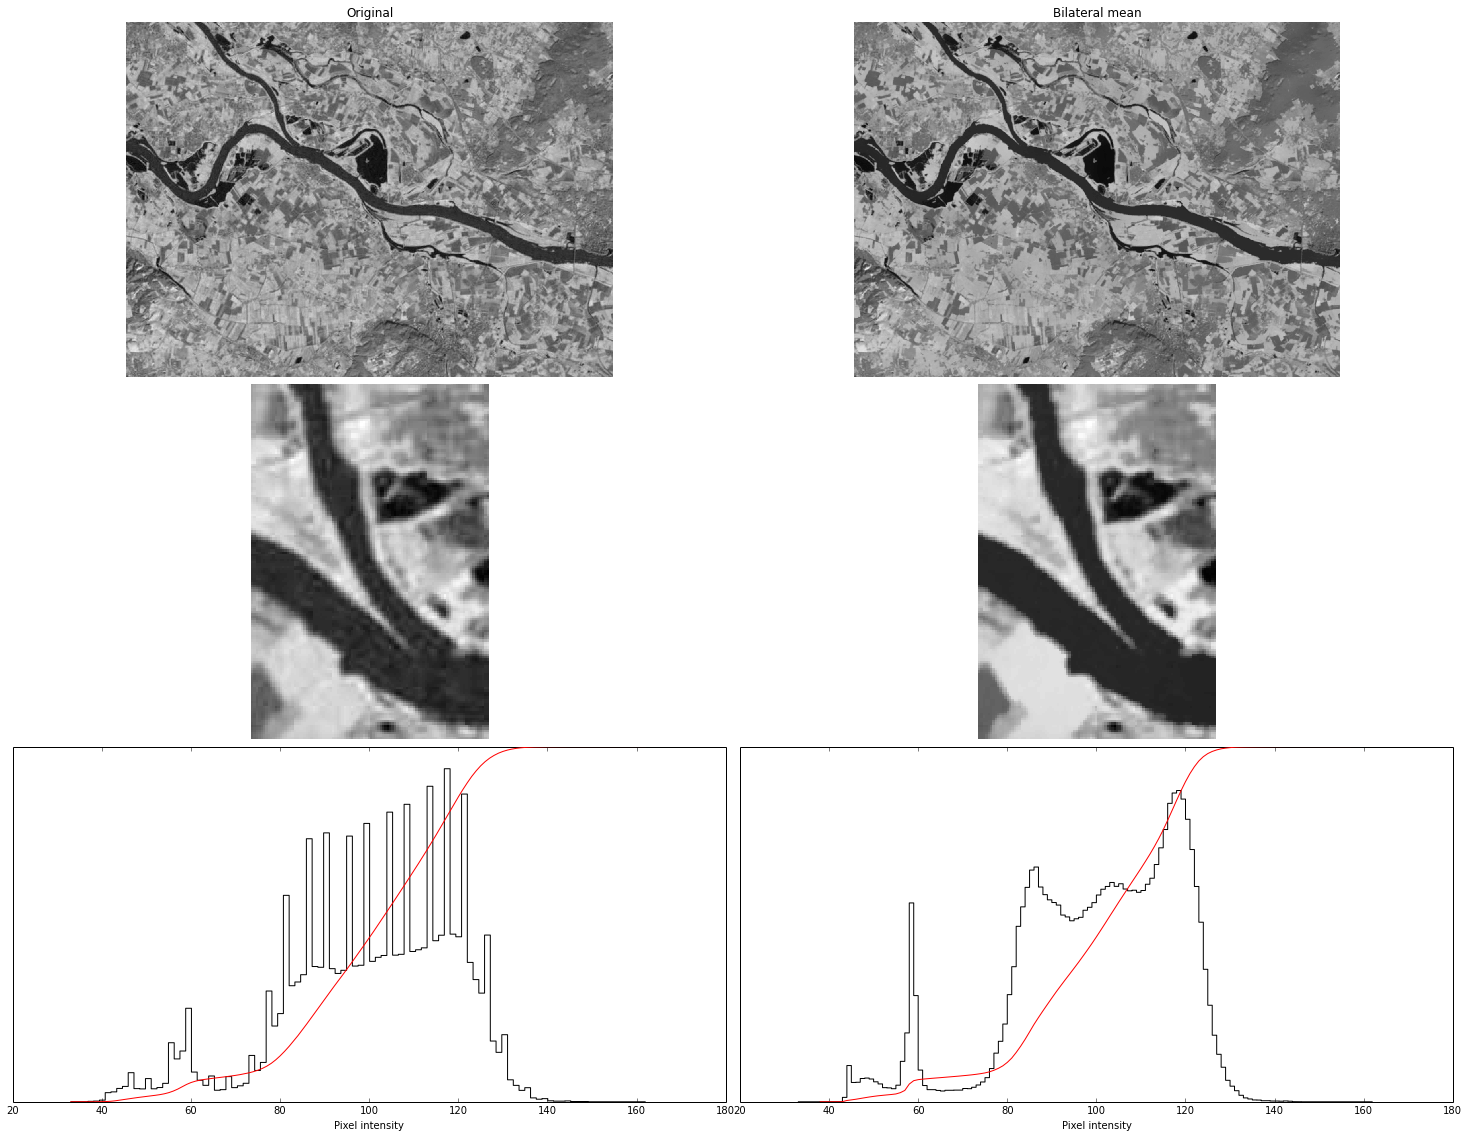

In [8]:
path = r'..\data\Willem_1\landsat_1985_0036_021_row0024_path0198.jpg'

from skimage import exposure
from skimage.color import rgb2gray
from skimage.filter.rank import mean_bilateral
from skimage import img_as_ubyte
from skimage.morphology import disk

im = imread(path)
im_grey = rgb2gray(im)
im_uint = img_as_ubyte(im_grey).astype(np.uint16)

result = mean_bilateral(im_uint, disk(20), s0=10, s1=10)

show_comparison(im_uint, result, 'Original', 'Bilateral mean', 200, 350, 350, 450, True, True)

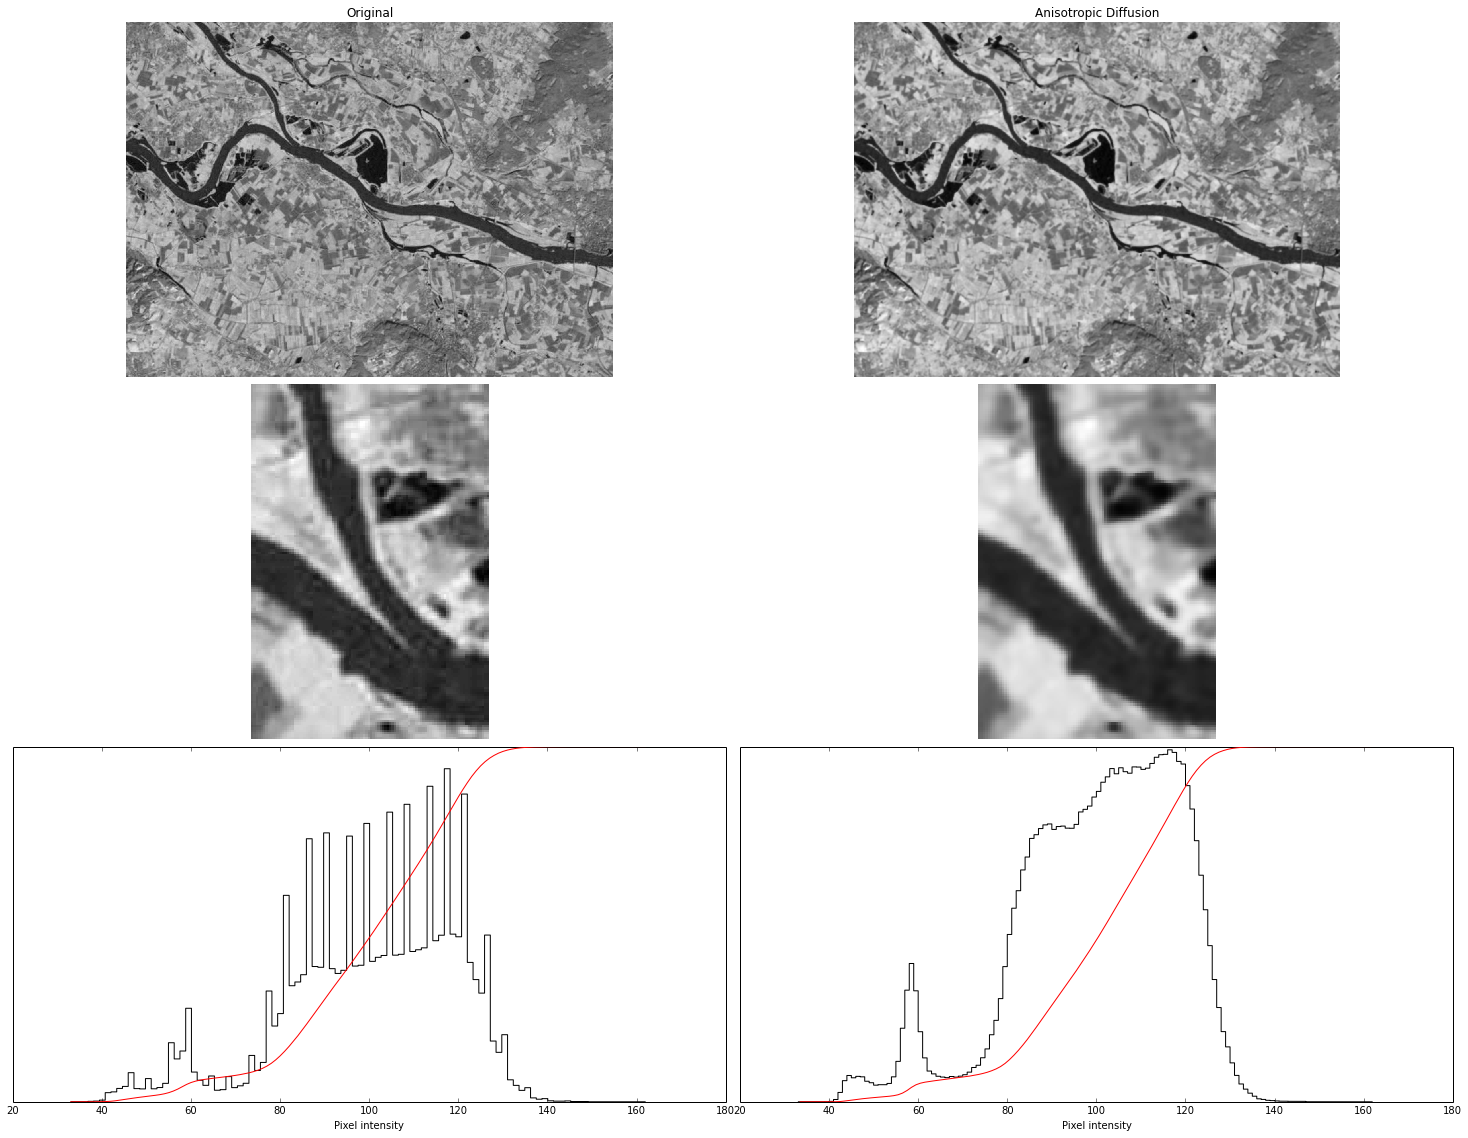

In [3]:
import adiff

result = adiff.anisodiff(im_uint, niter=10, kappa=25)

show_comparison(im_uint, result, 'Original', 'Anisotropic Diffusion', 200, 350, 350, 450, True, True)

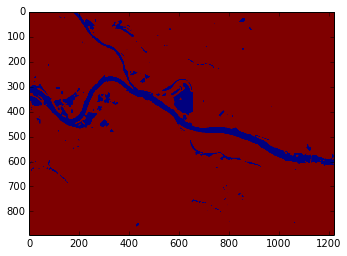

In [4]:
from scipy import ndimage as nd

# historgram based segmentation
n=10
l=256
im2 = nd.gaussian_filter(im, sigma=l/(4.*n))
mask = (result > 65)
#mask += 0.1 * im2
imshow(mask)

# >>> #
# >>> img = mask + 0.2*np.random.randn(*mask.shape)
# >>> #
# >>> hist, bin_edges = np.histogram(img, bins=60)
#>>> bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
#>>> #
#>>> binary_img = img > 0.5

Slic number of segments: 300


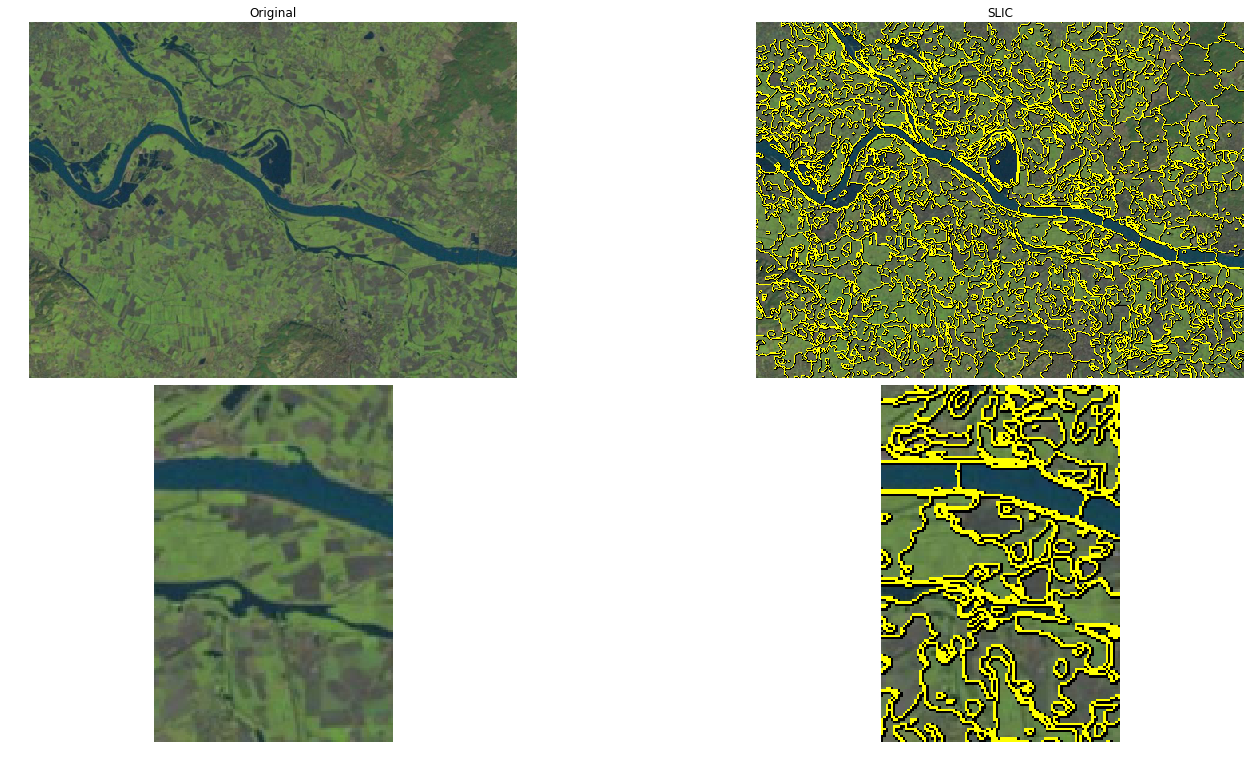

In [5]:
from __future__ import print_function

from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = img_as_float(im[::2, ::2])

segments_slic = slic(img, n_segments=300, compactness=10, sigma=1)

print("Slic number of segments: %d" % len(np.unique(segments_slic)))

show_comparison(img, mark_boundaries(img, segments_slic), 'Original', 'SLIC', 200, 350, 350, 450)

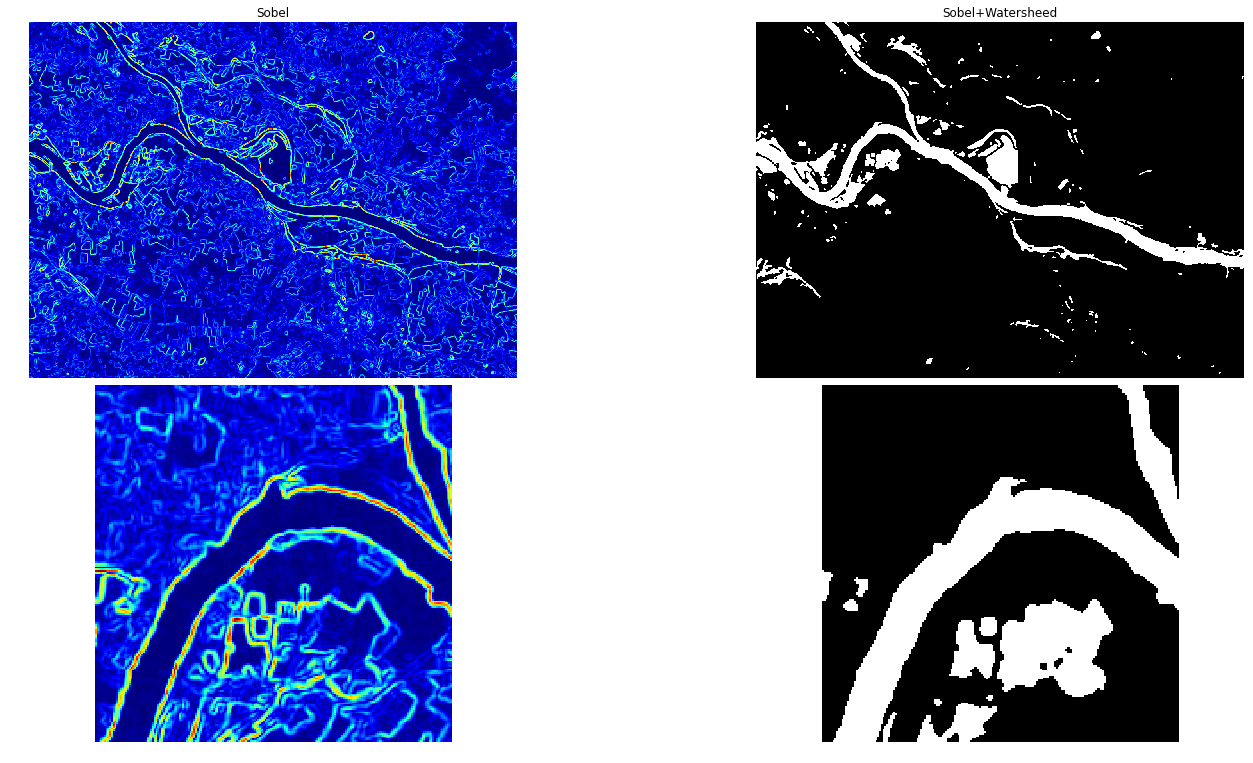

In [10]:
from skimage.filter import sobel
from skimage.morphology import watershed
from scipy import ndimage as nd

result = mean_bilateral(im_uint, disk(20), s0=10, s1=10)

edges = sobel(result)
markers = np.zeros_like(result)
foreground, background = 1, 2

# how to find these parameters, histogram analysis?
markers[result < 65.0] = background
markers[result > 90.0] = foreground

ws = watershed(edges, markers)
seg1 = nd.label(ws == foreground)[0]

show_comparison(edges, ws, 'Sobel', 'Sobel+Watersheed', 200, 400, 200, 400, cmap1=plt.cm.jet)

(-0.5, 1221.5, 893.5, -0.5)

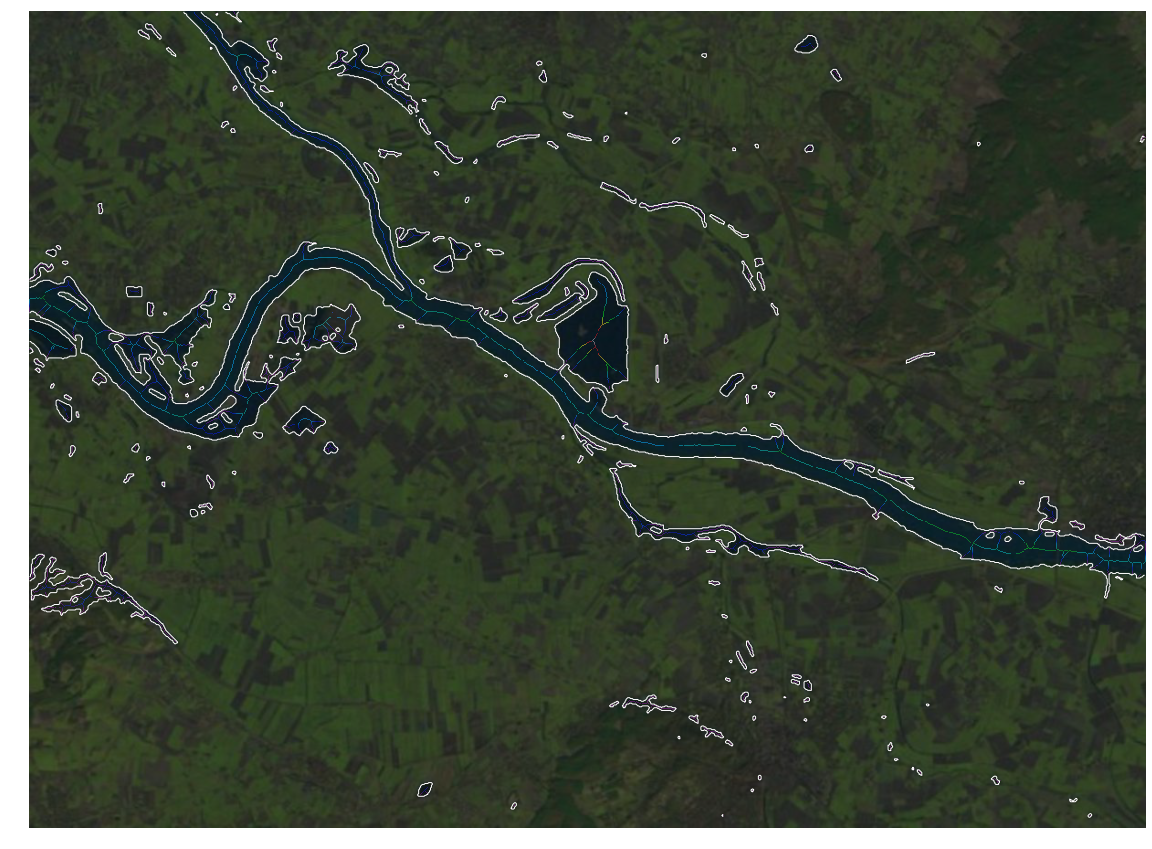

In [11]:
from scipy import ndimage
from skimage.morphology import medial_axis

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(ws == 2, return_distance=True)

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

fig, ax = plt.subplots(figsize=(20, 15))
ax.imshow(im)
ax.imshow(dist_on_skel, alpha=0.5, cmap=plt.cm.spectral, interpolation='nearest')
ax.contour(ws, [1.999], colors='w')
ax.axis('off')


In [1]:
import skimage.segmentation

In [ ]:
# arguments for slic
# skimage.segmentation.slic(n_segments=200,convert2lab=False, multichannel=True)

In [ ]:
# code from Ronald - fix!

# save waterbodies to TIF and GEOJSON
import rasterio
from subprocess import call
waterbodies = ws_bilateral.astype(uint8)
with rasterio.open(path) as src: pass # only metadata is needed from input jpg
kwargs = src.meta
kwargs.update(driver='GTiff', count=1)
with rasterio.open('waterbodies.tif', 'w', **kwargs) as dst:
    dst.set_crs('EPSG:3857') # WGS84-pseudo mercator
    dst.write_band(1, waterbodies)
with open('waterbodies.json', 'w') as f:
    call(['rio', 'shapes', '--projected', 'waterbodies.tif'], stdout=f)


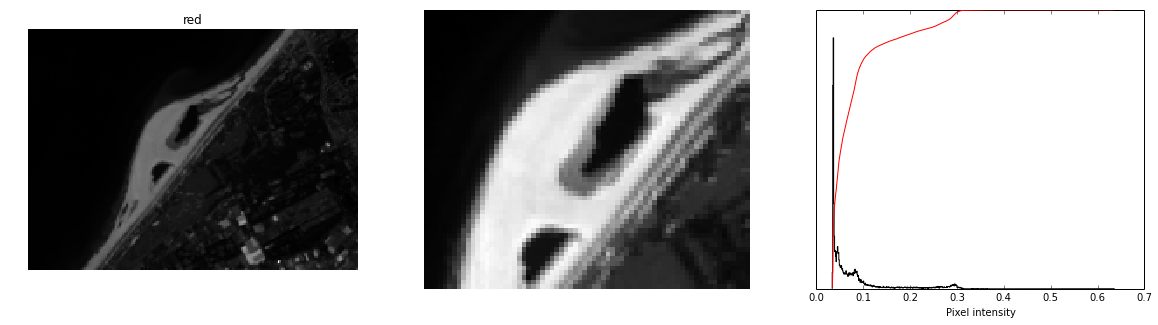

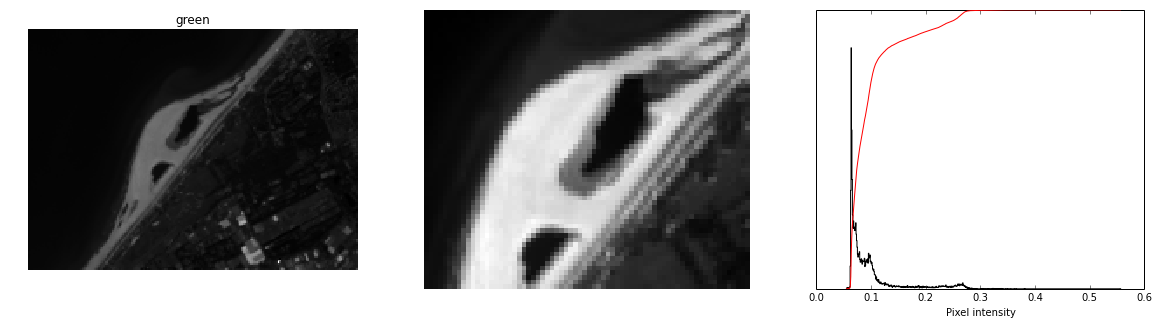

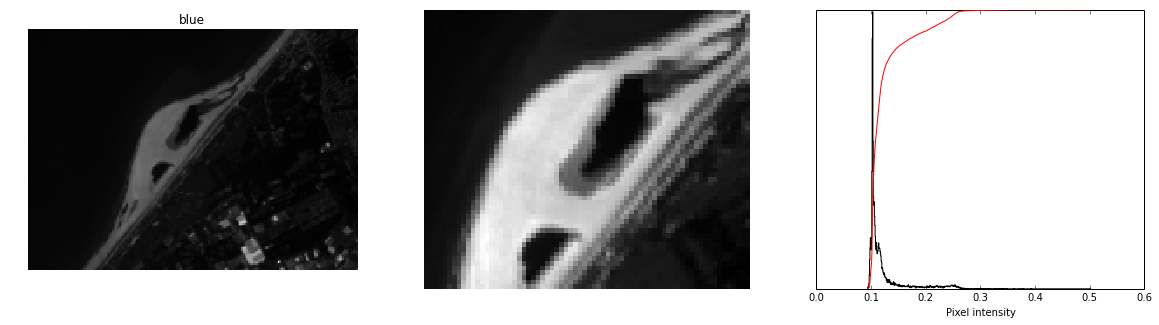

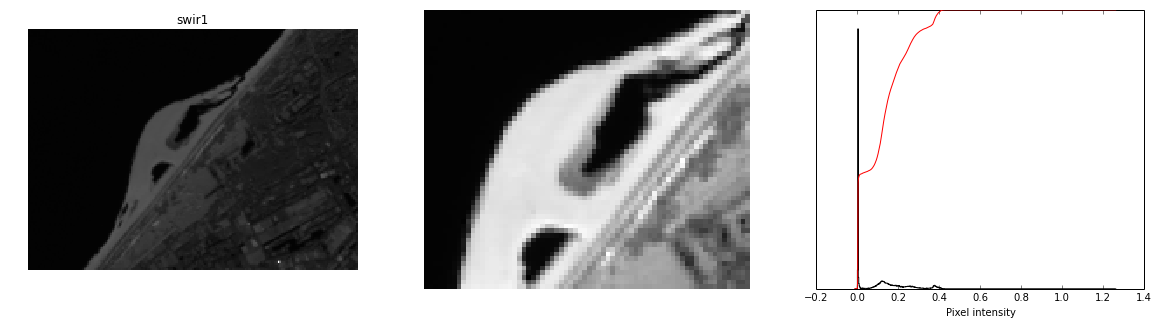

In [14]:
import glob
from PIL import Image

path_red = glob.glob(r'D:\gis\papers\coastline\Zandmotor\Zaandmotor_zoom\red*_2013-09-30.tif')[0]
path_green = glob.glob(r'D:\gis\papers\coastline\Zandmotor\Zaandmotor_zoom\green.green_2013-09-30.tif')[0]
path_blue = glob.glob(r'D:\gis\papers\coastline\Zandmotor\Zaandmotor_zoom\blue*_2013-09-30.tif')[0]
path_nir = glob.glob(r'D:\gis\papers\coastline\Zandmotor\Zaandmotor_zoom\nir*09-30.tif')[0]
path_swir1 = glob.glob(r'D:\gis\papers\coastline\Zandmotor\Zaandmotor_zoom\swir1*09-30.tif')[0]
path_swir2 = glob.glob(r'D:\gis\papers\coastline\Zandmotor\Zaandmotor_zoom\swir2*09-30.tif')[0]

red = np.asarray(Image.open(path_red))
green = np.asarray(Image.open(path_green))
blue = np.asarray(Image.open(path_blue))
nir = np.asarray(Image.open(path_nir))
swir1 = np.asarray(Image.open(path_swir1))
swir2 = np.asarray(Image.open(path_swir2))

show_im(red, 'red', 50, 120, 30, 90)
plt.show()

show_im(green, 'green', 50, 120, 30, 90)
plt.show()

show_im(blue, 'blue', 50, 120, 30, 90)
plt.show()

show_im(swir1, 'swir1', 50, 120, 30, 90)
plt.show()

mndwi = (green - swir1)/(green + swir1)
ndwi = (green - nir)/(green + nir)
ndvi = (nir - red)/(nir + red)

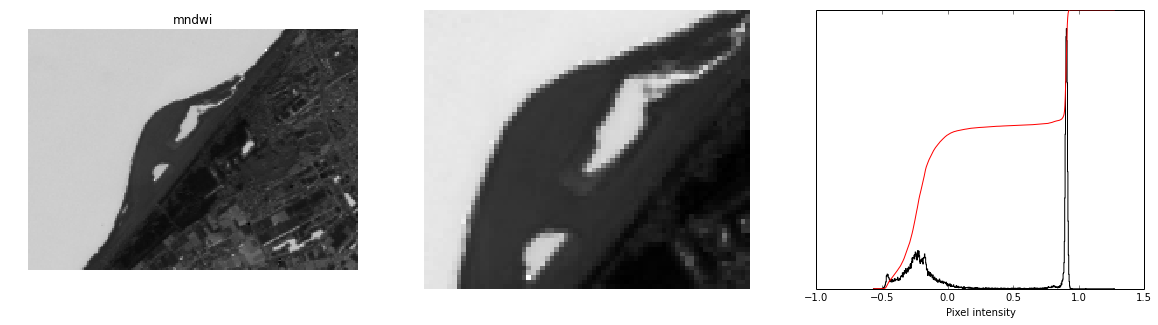

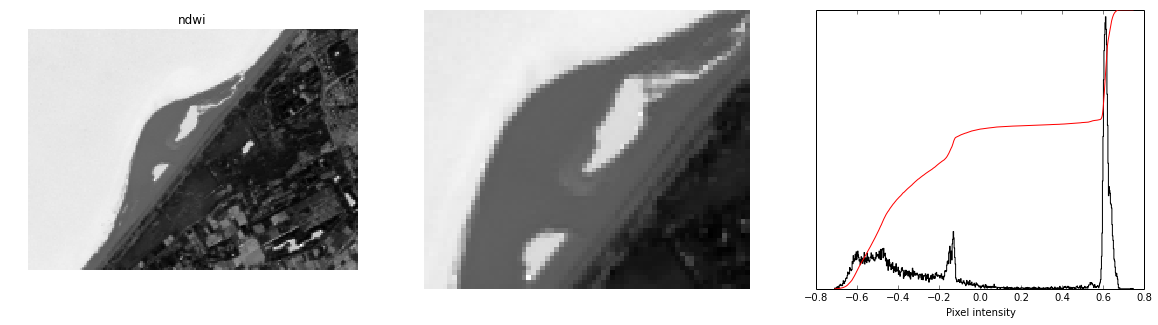

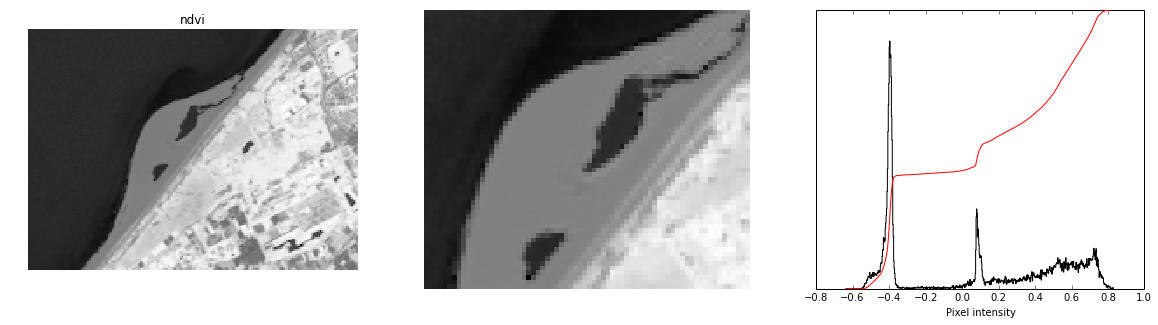

In [186]:
show_im(mndwi, 'mndwi', 50, 120, 30, 90)
plt.show()

show_im(ndwi, 'ndwi', 50, 120, 30, 90)
plt.show()

show_im(ndvi, 'ndvi', 50, 120, 30, 90)
plt.show()

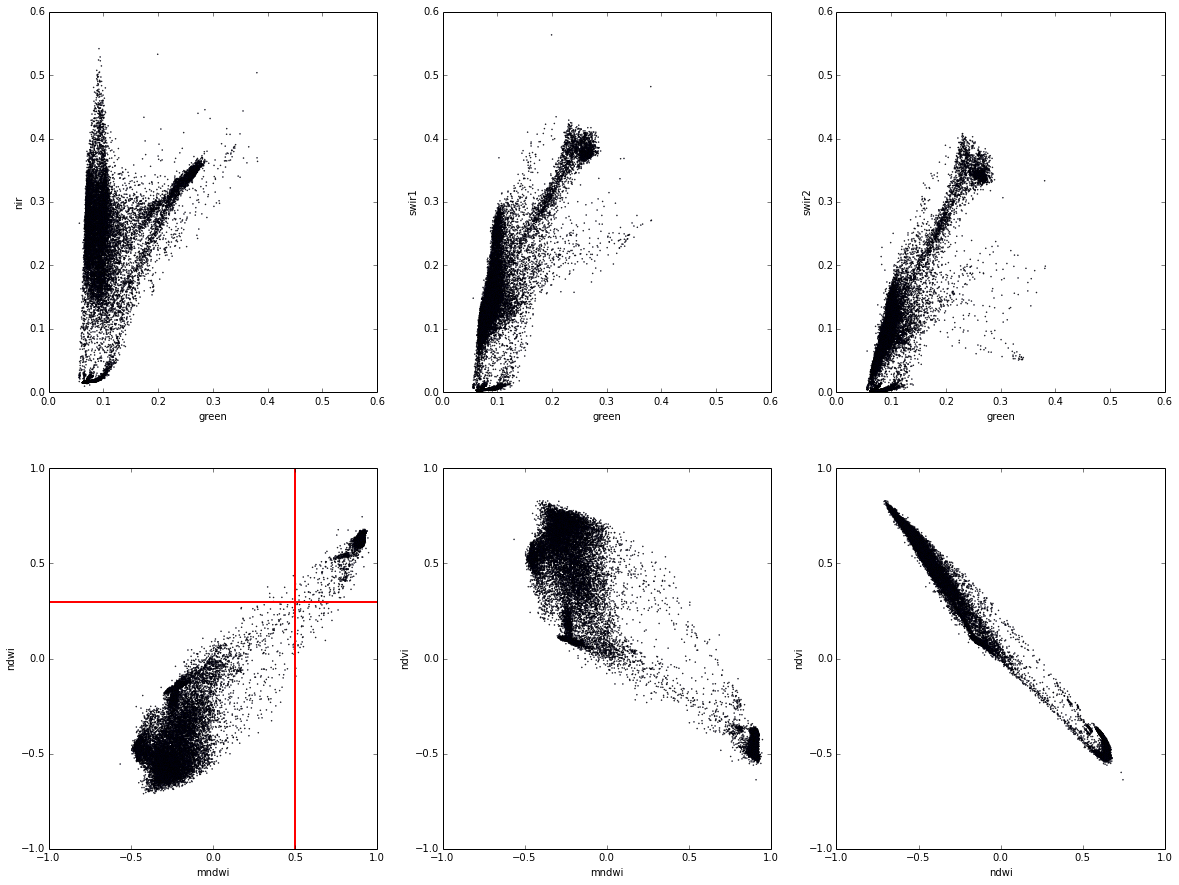

In [189]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()
ax1.scatter(green, nir, marker='.', s=1); ax1.set_xlim(0, 0.6); ax1.set_ylim(0, 0.6); ax1.set_xlabel('green'); ax1.set_ylabel('nir');
ax2.scatter(green, swir1, marker='.', s=1); ax2.set_xlim(0, 0.6); ax2.set_ylim(0, 0.6); ax2.set_xlabel('green'); ax2.set_ylabel('swir1');
ax3.scatter(green, swir2, marker='.', s=1); ax3.set_xlim(0, 0.6); ax3.set_ylim(0, 0.6); ax3.set_xlabel('green'); ax3.set_ylabel('swir2');
ax4.scatter(mndwi, ndwi, marker='.', s=1); ax4.set_xlim(-1, 1); ax4.set_ylim(-1, 1); ax4.set_xlabel('mndwi'); ax4.set_ylabel('ndwi');
ax5.scatter(mndwi, ndvi, marker='.', s=1); ax5.set_xlim(-1, 1); ax5.set_ylim(-1, 1); ax5.set_xlabel('mndwi'); ax5.set_ylabel('ndvi');
ax6.scatter(ndwi, ndvi, marker='.', s=1); ax6.set_xlim(-1, 1); ax6.set_ylim(-1, 1); ax6.set_xlabel('ndwi'); ax6.set_ylabel('ndvi');

ax4.plot([0.5, 0.5], [-1, 1], color='r', linestyle='-', linewidth=2)
ax4.plot([-1, 1], [0.3, 0.3], color='r', linestyle='-', linewidth=2)

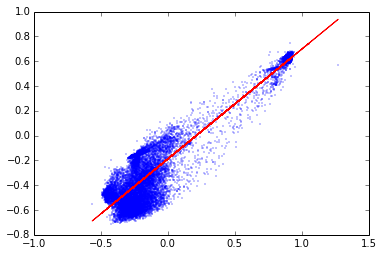

0.122615204613


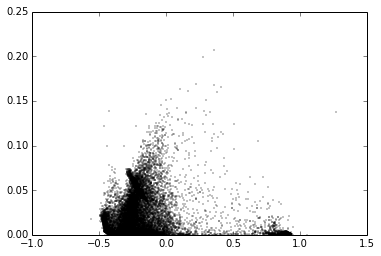

In [249]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import arange,array,ones,linalg

x = mndwi.ravel()
A = array([x, ones(len(x))])
y = ndwi.ravel()
w = linalg.lstsq(A.T,y)[0] # obtaining the parameters
line = w[0] * x + w[1] # regression line

plot(x, y, '.', x, line, 'r-', ms=1)
show()

print(sqrt(mean_squared_error(y_true=y, y_pred=line)))

plot(x, (y - line)**2, 'k.', ms=1)
show()


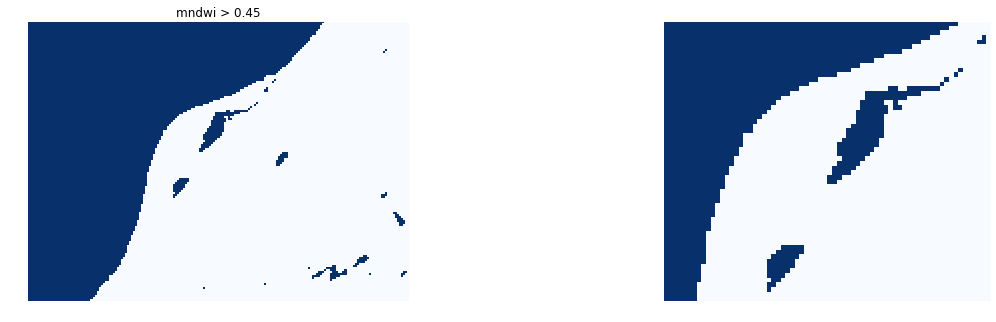

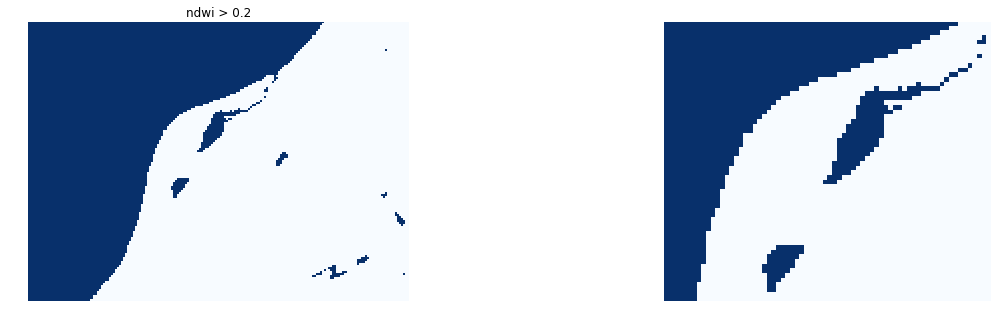

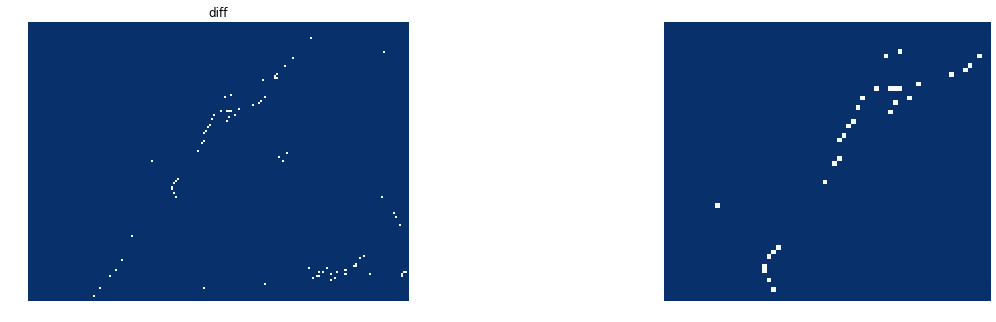

In [259]:
th = 0.45
mndwi_th = mndwi.copy()
mndwi_th[mndwi < th] = 0; mndwi_th[mndwi >= th] = 1
show_im(mndwi_th, 'mndwi > ' + str(th), 50, 120, 30, 90, plt.cm.Blues, histogram=False)
plt.show()

th = 0.2
ndwi_th = ndwi.copy()
ndwi_th[ndwi < th] = 0; ndwi_th[ndwi >= th] = 1;
show_im(ndwi_th, 'ndwi > ' + str(th), 50, 120, 30, 90, plt.cm.Blues, histogram=False)
plt.show()

diff = ndwi_th.copy(); diff[ndwi_th != mndwi_th] = 0; diff[ndwi_th == mndwi_th] = 1;
show_im(diff, 'diff', 50, 120, 30, 90, plt.cm.Blues, histogram=False)
plt.show()




(-0.5, 2580.5, 1010.5, -0.5)

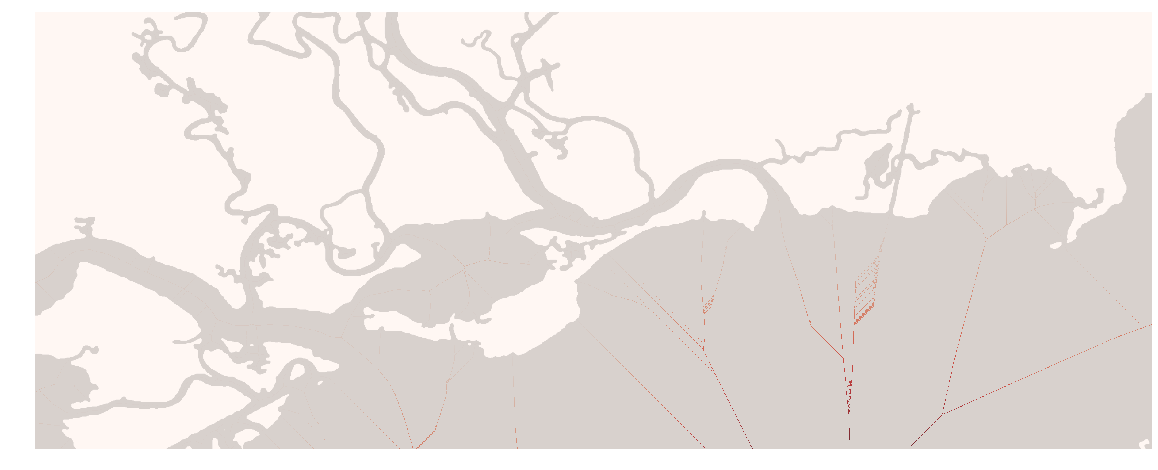

In [19]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage.io import imread
from skimage.morphology import medial_axis

im = imread('earth_gridgen_example1.tif')

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(im == 1, return_distance=True)

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

fig, ax = plt.subplots(figsize=(20, 15))
ax.imshow(im, cmap=plt.cm.Greys, alpha=0.5)
ax.imshow(dist_on_skel, alpha=0.7, cmap=plt.cm.Reds, interpolation='nearest')
ax.axis('off')



(-0.5, 2580.5, 1010.5, -0.5)

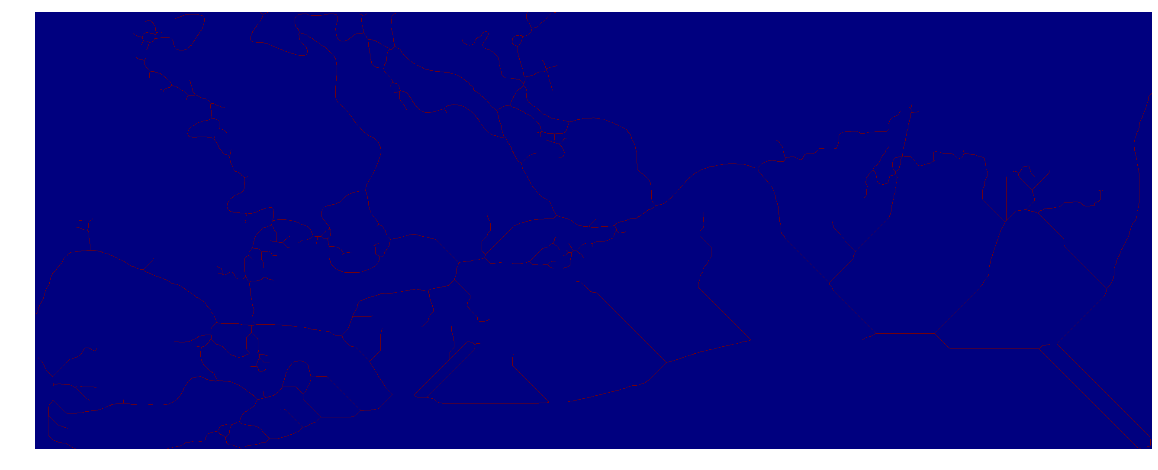

In [14]:
from skimage.morphology import skeletonize
skel = skeletonize(im)

fig, ax = plt.subplots(figsize=(20, 15))
#ax.imshow(im)
ax.imshow(skel)
ax.axis('off')

